# One-Shot Learning using Siamese Network in FastEstimator

This notebook demonstrates how to perform one-shot learning using Siamese Network in FastEstimator.

In one-shot learning we classify based on only a single example of each class. This ability of being able to learn from very little data could be useful in many machine learning problems.
The details of the method are present in [Siamese neural networks for one-shot image recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
We will use Omniglot dataset for training and evaluation. The Omniglot dataset consists of 50 different alphabets split into background(30 alphabets) and evaluation(20 alphabets) sets.Each alphabet has a number of characters and each character has 20 images each.

In [1]:
import tempfile

import os
import cv2
import numpy as np

import tensorflow as tf
import fastestimator as fe

from matplotlib import pyplot as plt

## Building Components

### Step1: Create pipeline

In [2]:
from fastestimator.dataset import omniglot

train_data, eval_data = omniglot.load_data()
test_data = eval_data.split(0.5)

For training, batches of data are created with half of the batch consisting of image pair from the same character and other half consiting of image pair from different characters. The target label is 1 for image pair from the same character and 0 otherwise. The aim is to learn similarity between any given pair of images.

In [3]:
# Parameters
epochs = 200
batch_size = 128

In [4]:
from fastestimator.op.numpyop import ReadImage, Sometimes, ShiftScaleRotate, Minmax

pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="x_a", outputs="x_a", grey_scale=True),
        ReadImage(inputs="x_b", outputs="x_b", grey_scale=True),
        Sometimes(
            ShiftScaleRotate(image_in="x_a",
                             image_out="x_a",
                             shift_limit=0.05,
                             scale_limit=0.2,
                             rotate_limit=10.0,
                             mode="train"),
            prob=0.89),
        Sometimes(
            ShiftScaleRotate(image_in="x_b",
                             image_out="x_b",
                             shift_limit=0.05,
                             scale_limit=0.2,
                             rotate_limit=10.0,
                             mode="train"),
            prob=0.89),
        Minmax(inputs="x_a", outputs="x_a"),
        Minmax(inputs="x_b", outputs="x_b")
    ])

We can visualize sample images from the ``pipeline`` using ``show_results`` method.

Image pair from same character


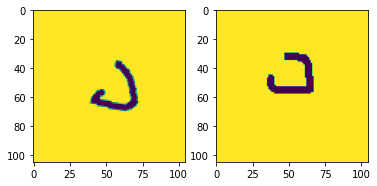

Image pair from different characters


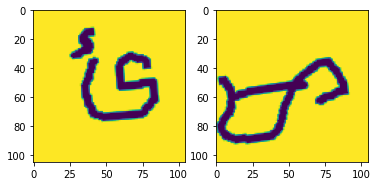

In [5]:
sample_batch = pipeline.get_results()

similar_img_a = sample_batch["x_a"][0]
similar_img_b = sample_batch["x_b"][0]

dissimilar_img_a = sample_batch["x_a"][batch_size-1]
dissimilar_img_b = sample_batch["x_b"][batch_size-1]

if sample_batch["y"][0] ==1:
    print('Image pair from same character')
else:
    print('Image pair from different characters')
    
plt.subplot(121)
plt.imshow(np.squeeze(similar_img_a))

plt.subplot(122)
plt.imshow(np.squeeze(similar_img_b))

plt.show()

if sample_batch["y"][1] ==1:
    print('Image pair from same character')
else:
    print('Image pair from different characters')
    
plt.subplot(121)
plt.imshow(np.squeeze(dissimilar_img_a))

plt.subplot(122)
plt.imshow(np.squeeze(dissimilar_img_b))

plt.show()

### Step2: Create network

Siamese network has two convolutional arms which accept distinct inputs. However, the weights on both these convolutional arms are shared. Each convolutional arm works as a feature extractor which produces a feature vector. L1 component-wise distance between these vectors is computed which is used to classify whether the image pair belongs to same or different classes. 

In [6]:
from tensorflow.python.keras import Model, layers, Sequential
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.regularizers import l2
    

def siamese_network(input_shape=(105, 105, 1), classes=1):
    left_input = layers.Input(shape=input_shape)
    right_input = layers.Input(shape=input_shape)

    #Creating the convnet which shares weights between the left and right legs of Siamese network
    siamese_convnet = Sequential()

    siamese_convnet.add(
        layers.Conv2D(filters=64,
                      kernel_size=10,
                      strides=1,
                      input_shape=input_shape,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=128,
                      kernel_size=7,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=128,
                      kernel_size=4,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=256,
                      kernel_size=4,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.Flatten())

    siamese_convnet.add(
        layers.Dense(4096,
                     activation='sigmoid',
                     kernel_initializer=RandomNormal(mean=0, stddev=0.2),
                     kernel_regularizer=l2(1e-4),
                     bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    encoded_left_input = siamese_convnet(left_input)
    encoded_right_input = siamese_convnet(right_input)

    l1_encoded = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_left_input, encoded_right_input])

    output = layers.Dense(classes,
                          activation='sigmoid',
                          kernel_initializer=RandomNormal(mean=0, stddev=0.2),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01))(l1_encoded)

    return Model(inputs=[left_input, right_input], outputs=output)

We now prepare the `model` and define a `Network` object.

In [7]:
from tensorflow.keras.optimizers import Adam
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


model = fe.build(model_fn=siamese_network, model_names="siamese_net", optimizer_fn="adam")

network = fe.Network(ops=[
    ModelOp(inputs=["x_a", "x_b"], model=model, outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

In this example we will also use the following traces:
1. LRScheduler with a constant decay schedule as described in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
2. BestModelSaver for saving the best model. For illustration purpose, we will save these models in temporary directory.
3. EarlyStopping for stopping training if the monitored metric doesn't improve within specified number of epochs.
4. Custom trace to calculate one shot classification accuracy as described in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
It's a 20-way within-alphabet classiﬁcation task in which an alphabet is ﬁrst chosen from among those reserved for the evaluation set. Then, nineteen other characters are taken uniformly at random from the alphabet. The first charcter's image is compared with another image of the same character and with images of the other nineteen characters. This is called a one-shot trial. The trial is considered a success if the network outputs highest similarity (probability) for the image pair belonging to same character. 

In [8]:
from fastestimator.backend import feed_forward
from fastestimator.trace.adapt import LRScheduler, EarlyStopping
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.trace import Trace
from fastestimator.util import Data


def lr_schedule(epoch):
    lr = 0.0001*np.power(0.99, epoch)
    return lr


class OneShotAccuracy(Trace):
    def __init__(self, dataset, model, N=20, trials=400, mode=["eval", "test"], output_name="one_shot_accuracy"):

        super().__init__(mode=mode, outputs=output_name)
        self.dataset = dataset
        self.model = model
        self.total = 0
        self.correct = 0
        self.output_name = output_name
        self.N = N
        self.trials = trials

    def on_epoch_begin(self, data: Data):
        self.total = 0
        self.correct = 0

    def on_epoch_end(self, data: Data):
        for _ in range(self.trials):
            img_path = self.dataset.one_shot_trial(self.N)
            input_img = (np.array([np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), -1) / 255. for i in img_path[0]],
                                  dtype=np.float32),
                         np.array([np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), -1) / 255. for i in img_path[1]],
                                  dtype=np.float32))
            prediction_score = feed_forward(self.model, input_img, training=False).numpy()

            if np.argmax(prediction_score) == 0 and prediction_score.std() > 0.01:
                self.correct += 1

            self.total += 1

        data.write_with_log(self.outputs[0], self.correct / self.total)

        
# Model directory
save_dir=tempfile.mkdtemp()
os.makedirs(save_dir, exist_ok=True)
        
traces = [
    LRScheduler(model=model, lr_fn=lr_schedule),
    Accuracy(true_key="y", pred_key="y_pred"),
    OneShotAccuracy(dataset=eval_data, model=model, output_name='one_shot_accuracy'),
    BestModelSaver(model=model, save_dir=save_dir, metric="one_shot_accuracy", save_best_mode="max"),
    EarlyStopping(monitor="one_shot_accuracy", patience=20, compare='max', mode="eval")
]

### Step3: Create estimator

In [9]:
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=epochs, traces=traces)

## Training and Testing

In [10]:
# Training
estimator.fit()

Now, we can load the best model to check the one shot accuracy on test set

In [11]:
# Testing
fe.backend.load_model(model, os.path.join(save_dir, 'siamese_net_best_one_shot_accuracy.h5'))
estimator.test()

Loaded model weights from /tmp/tmpt5dfnobc/siamese_net_best_one_shot_accuracy.h5
FastEstimator-Test: epoch: 140; accuracy: 0.9340909090909091; one_shot_accuracy: 0.81; 


## Inferencing

Below, we are infering results on the test dataset. Here, we generate 5-way one shot trial for demo purposes.

In [12]:
#Generating one-shot trial set for 5-way one shot trial
img_path = test_data.one_shot_trial(5)
input_img = (np.array([np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), -1) / 255. for i in img_path[0]],
                      dtype=np.float32),
             np.array([np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), -1) / 255. for i in img_path[1]],
                      dtype=np.float32))

prediction_score = feed_forward(model, input_img, training=False).numpy()

The test image is predicted to be belonging to the class with the maximum similarity. 

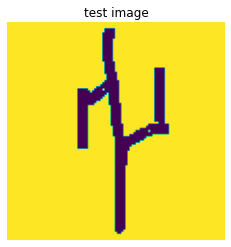

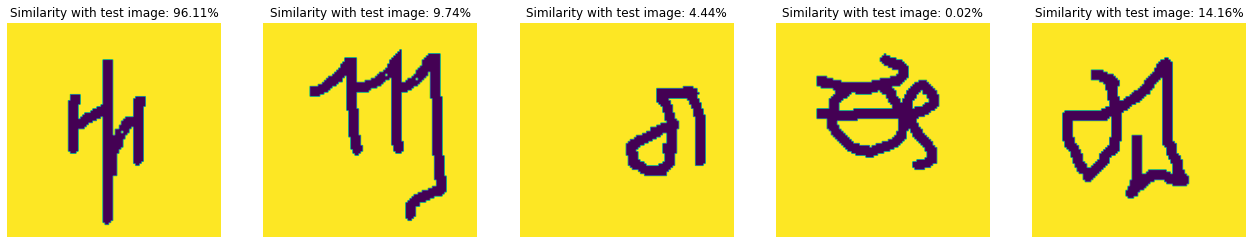

In [13]:
plt.figure(figsize=(4, 4))
plt.imshow(np.squeeze(input_img[0][0]));
plt.title('test image')
plt.axis('off');
plt.show()

plt.figure(figsize=(18, 18))
plt.subplot(151)
plt.imshow(np.squeeze(input_img[1][0]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[0][0]))
plt.axis('off');

plt.subplot(152)
plt.imshow(np.squeeze(input_img[1][1]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[1][0]))
plt.axis('off');

plt.subplot(153)
plt.imshow(np.squeeze(input_img[1][2]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[2][0]))
plt.axis('off');

plt.subplot(154)
plt.imshow(np.squeeze(input_img[1][3]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[3][0]))
plt.axis('off');

plt.subplot(155)
plt.imshow(np.squeeze(input_img[1][4]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[4][0]))
plt.axis('off');

plt.tight_layout()